In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats

from utils import sliding_average, savefig, plot_with_std, get_datetime_str, load_data
from params import human_index, question_title_map

In [2]:
df = load_data(conditions=[2, 3])
df.head()

,participantId,ideology_all_zeros,idx_of_question,who_answers_first,bot_detection,ideology,ideology_distance,bot_ideology,answer,answer_distance,bot_answer,affection_competence,affection_warmth
0,009AFBEE6704466A96A1BDFDF031CACC,True,1,1,False,0.0,"[0, 0]","[0.0, 0.0]",-3.0,3.000000,"[-0.7667446799252016, -0.06023742871329407]",1,0
1,009AFBEE6704466A96A1BDFDF031CACC,True,2,2,False,0.0,0,[0.0],0.2,2.466667,[-2.2666666666666666],1,0
2,009AFBEE6704466A96A1BDFDF031CACC,True,5,1,False,0.0,"[0, 0]","[0.0, 0.0]",-3.0,3.000000,"[-0.38337297849552066, 0.09974430142874313]",1,0
3,009AFBEE6704466A96A1BDFDF031CACC,True,0,0,False,0.0,0,[0.0],1.0,0.300000,[1.3],1,0
4,009AFBEE6704466A96A1BDFDF031CACC,True,4,0,False,0.0,0,[0.0],-1.0,3.200000,[2.2],1,0


## Relationship between participant's ideology and his answer (not answer distance with bot)

The mean opinions of ideology group -2~-1 and -1~0 don't have a significant difference, p=0.32
The mean opinion of ideology group 1~2 is significantly greater than that of group 0~1.


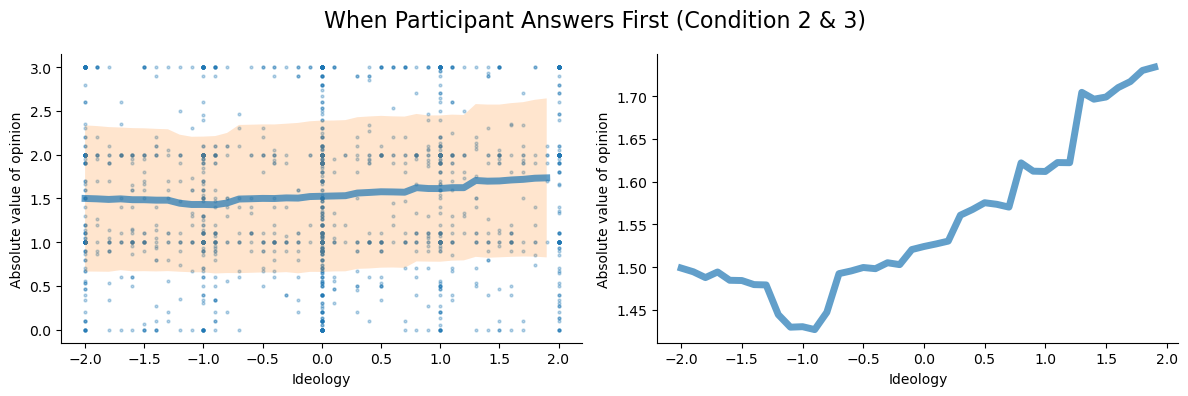

In [3]:
df_grouped = df.set_index(['participantId', 'idx_of_question'])
df_sorted = df_grouped.sort_index(level=[0, 1])
df_sorted['ideology_group'] = df_sorted['ideology'].apply(lambda x: math.floor(min(x, 1.99))) + 2
df_human_first = df_sorted.loc[df_sorted['who_answers_first'] == human_index]

fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
x = df_human_first['ideology']
y = np.abs(df_human_first['answer'])
average, low, high = sliding_average(x, y)

for i in range(2):
    ax = axes[i]
    if i == 0:
        ax.scatter(x, y, s=4, alpha=0.3)
        plot_with_std(ax, average, low, high)
    else:
        ax.plot(average.index, average.values, alpha=0.7, lw=5)
    ax.set(
        xlabel="Ideology",
        ylabel="Absolute value of opinion",
    ) 
fig.suptitle("When Participant Answers First (Condition 2 & 3)", fontsize=16)
savefig(fig, f"visualization/{get_datetime_str()}-ideology_opinion.pdf")

for left_group, right_group in [[0, 1], [3, 2]]:
    left_group_ideologies = np.abs(df_sorted.loc[df_sorted['ideology_group'] == left_group]['answer'].values)
    right_group_ideologies = np.abs(df_sorted.loc[df_sorted['ideology_group'] == right_group]['answer'].values)
    t, p = scipy.stats.ttest_ind(left_group_ideologies, right_group_ideologies)
    if p < 0.05 and t > 0:
        print(f"The mean opinion of ideology group {left_group - 2}~{left_group - 1} is significantly greater than that of group {right_group - 2}~{right_group - 1}.")
    elif p < 0.05 and t < 0:
        print(f"The mean opinion of ideology group {left_group - 2}~{left_group - 1} is significantly smaller than that of group {right_group - 2}~{right_group - 1}.")
    else:
        print(f"The mean opinions of ideology group {left_group - 2}~{left_group - 1} and {right_group - 2}~{right_group - 1} don't have a significant difference, p={p:.2f}")

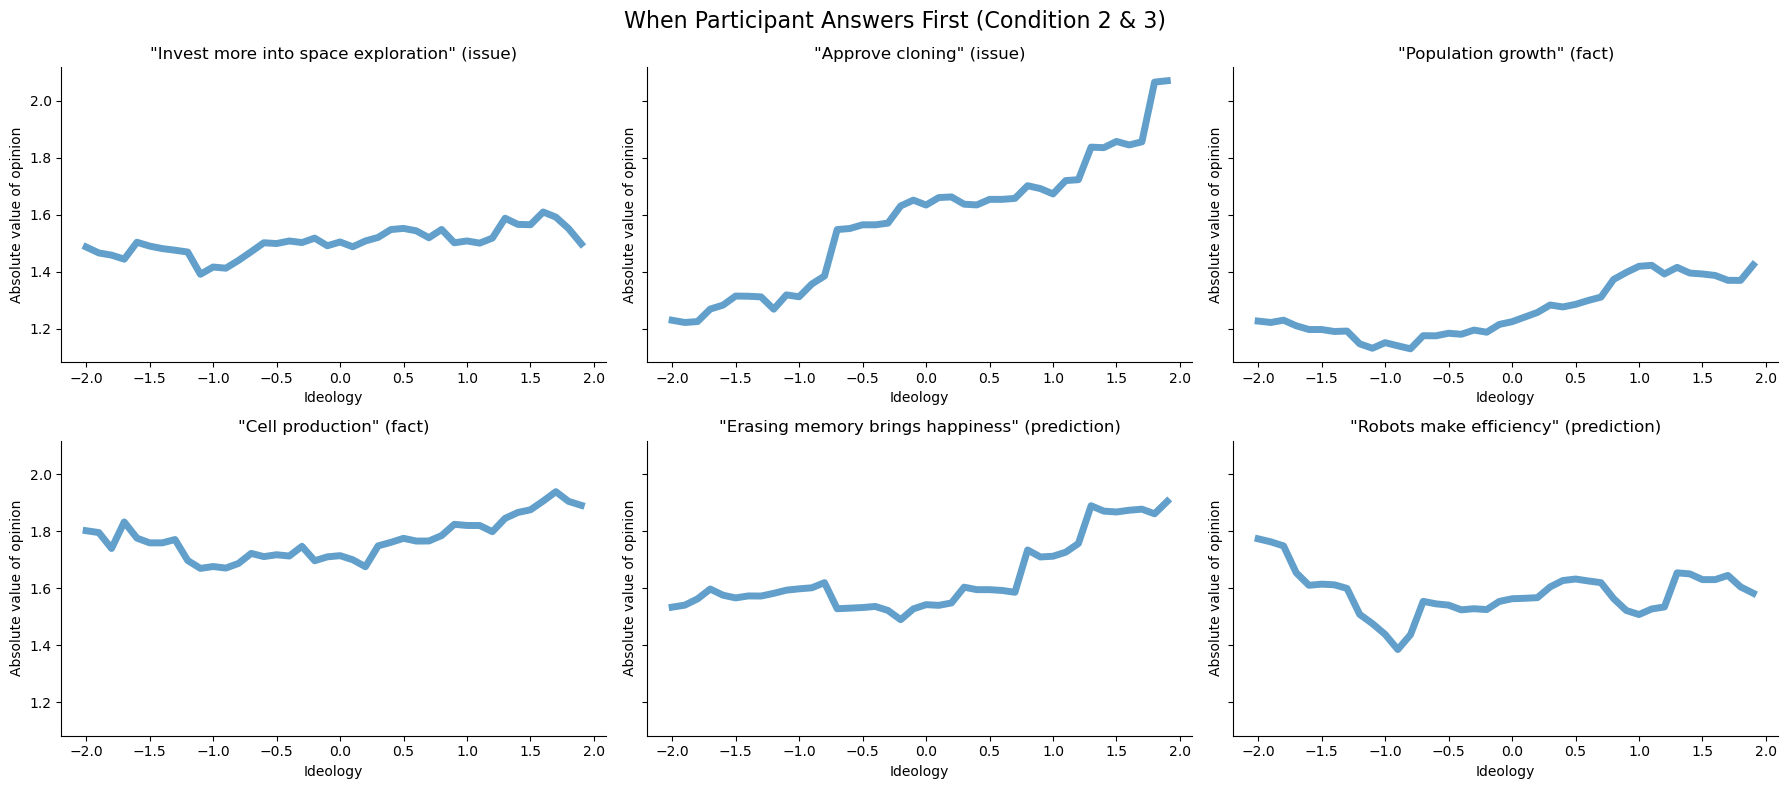

In [4]:
fig, axes = plt.subplots(figsize=(18, 8), nrows=2, ncols=3, sharey=True)

for question in range(6):
    df_question = df_human_first.swaplevel(0, 1).loc[question]
    row = question // 3
    col = question % 3
    ax = axes[row][col]

    x = df_question['ideology']
    y = np.abs(df_question['answer'])
    average, low, high = sliding_average(x, y)

    ax.plot(average.index, average.values, alpha=0.7, lw=5)
    ax.set(
        xlabel="Ideology",
        ylabel="Absolute value of opinion",
        title=f"{question_title_map[question]}"
    ) 
fig.suptitle("When Participant Answers First (Condition 2 & 3)", fontsize=16)
savefig(fig, f"visualization/{get_datetime_str()}-ideology_opinion-each_question.pdf")

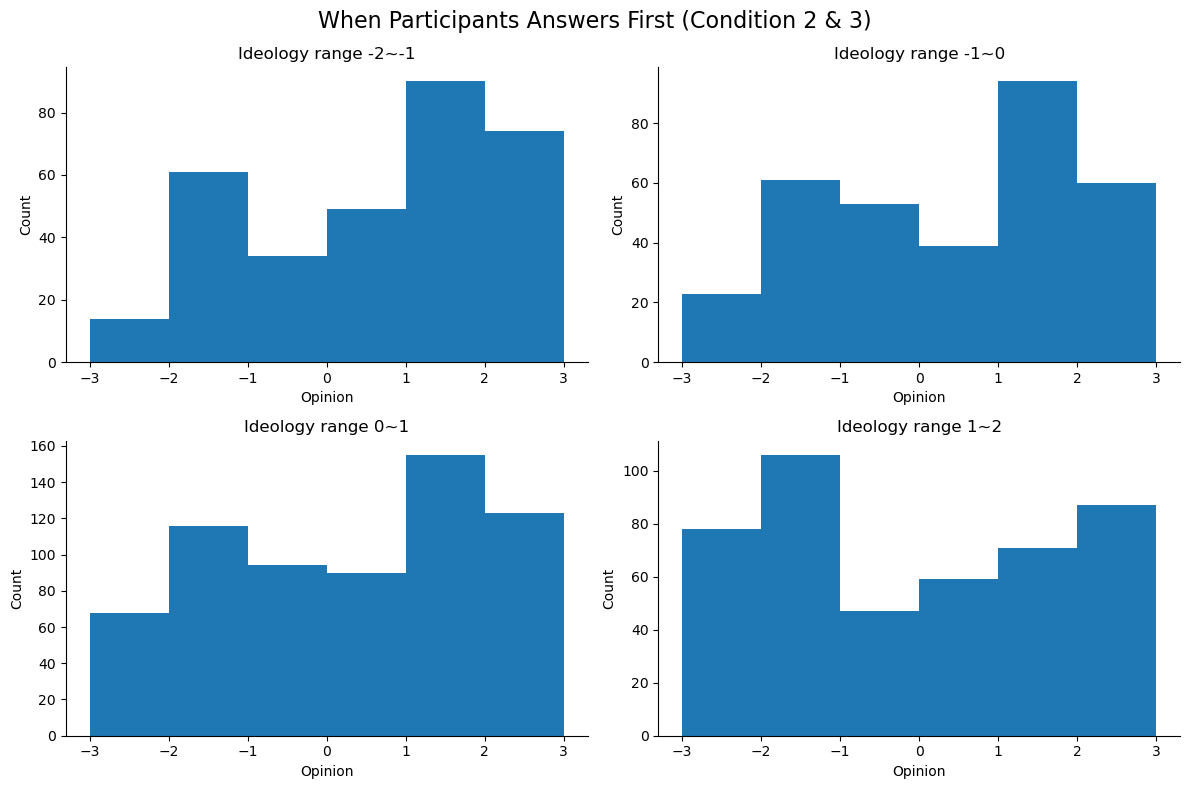

In [5]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=2, nrows=2)
for ideology_group in range(4):
    row = ideology_group // 2
    col = ideology_group % 2
    ax = axes[row][col]
    df_each_group = df_human_first.loc[df_human_first['ideology_group'] == ideology_group]
    ax.hist(df_each_group['answer'], bins=6)
    ax.set(
        xlabel="Opinion",
        ylabel="Count",
        title=f"Ideology range {ideology_group - 2}~{ideology_group - 1}"
    )
fig.suptitle("When Participants Answers First (Condition 2 & 3)", fontsize=16)
savefig(fig, f"visualization/{get_datetime_str()}-answer_histogram.pdf")

In [92]:
ideology_groups = ["Liberal", "Neutral", "Conservative"]
df = pd.read_csv("data/condition.csv")

df_2 = df.loc[df['condition'] == 2]
df_2 = df_2.loc[df_2['valid_ideologies']].set_index("participantId")
df_human_first = df_2.loc[df_2['who_answers_first'] == df_2['who']]
id_ideology = df_human_first.groupby('participantId')['ideology'].first()
id_group = pd.qcut(id_ideology, q=group_num, labels=ideology_groups)
df_2["human_ideology_group"] = id_group
df_2 = df_2.reset_index().set_index(["participantId", "who"])
total_pair_group = None
for group in ideology_groups:
    df_group = df_2.loc[df_2['human_ideology_group'] == group]
    df_group_bot = df_group.loc[df_group.index.get_level_values(1) != human_index]
    pair_ideology = df_group_bot.groupby(['participantId', "who"])['ideology'].first()
    pair_group = pd.qcut(pair_ideology, q=group_num, labels=ideology_groups)
    total_pair_group = pair_group if total_pair_group is None else pd.concat([pair_group, total_pair_group])
df_2["bot_ideology_group"] = total_pair_group
df_2.head()

idx_of_question  ideology      answer  \
participantId                    who                                          
0163CEF6924B41B5A70EE79DD42D6712 0                  2       2.0 -100.000000   
                                 1                  2       1.0   -1.666667   
                                 2                  2      -1.6 -100.000000   
                                 0                  0       2.0 -100.000000   
                                 1                  0       1.0    0.000000   

                                      condition  who_answers_first  \
participantId                    who                                 
0163CEF6924B41B5A70EE79DD42D6712 0            2                  1   
                                 1            2                  1   
                                 2            2                  1   
                                 0            2                  1   
                                 1            2                  1   

                                      bot_detection labels  valid_ideologies  \
participantId                    who                                           
0163CEF6924B41B5A70EE79DD42D6712 0            False    [2]              True   
                                 1            False    [3]              True   
                                 2            False    [0]              True   
                                 0            False    [2]              True   
                                 1            False    [3]              True   

                                     human_ideology_group bot_ideology_group  
participantId                    who                                          
0163CEF6924B41B5A70EE79DD42D6712 0           Conservative       Conservative  
                                 1           Conservative                NaN  
                                 2           Conservative            Liberal  
                                 0           Conservative       Conservative  
                                 1           Conservative                NaN